# Abstract

Machine learning plays a pivotal role in pathology classification, offering a transformative approach to the analysis and interpretation of medical images. In the field of pathology, the accurate and efficient identification of diseases, tumors, and anomalies within tissue samples is essential for timely diagnosis and treatment. Machine learning models, particularly deep learning algorithms, have demonstrated their prowess in automating and enhancing the accuracy of pathological image analysis. By leveraging vast datasets and training models to recognize subtle patterns and features, these technologies aid pathologists in making quicker and more precise diagnoses. Moreover, they enable the identification of novel biomarkers and predictive factors, advancing our understanding of diseases and paving the way for personalized treatment strategies. The adoption of machine learning in pathology classification not only improves patient care but also optimizes workflows and augments the capabilities of healthcare professionals, showcasing its profound significance in modern healthcare.

**Objective**: Detect metastatic tumor patches from stained histopathology data using machine learning

# Libraries

In [26]:
# Libraries

import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Data Import and Visualization

In [2]:
# Functions

def LoadFile(file_path):
    """This algorithm loads a HDF5 file and returns its content."""
    with h5py.File(file_path, "r") as f:
        data = f[list(f.keys())[0]][:]
    return data

def SampleVisualization(images, labels, num_samples=5):
    """Visualize random image samples with their labels."""
    indices = np.random.choice(len(images), num_samples, replace=False)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[idx])
        if 0 in labels[idx]:
            plt.title(f"Healthy")
        else:
            plt.title(f"Metastatic")
        plt.axis("off")
    plt.tight_layout()

def DataCheck(images, labels):
    """Algorithm that checks the data properties"""

    image_shape = images.shape
    label_shape = labels.shape
    label_distribution = np.unique(labels, return_counts=True)
    
    if image_shape[0] != label_shape[0]:
        print(f"Not all images have corresponding label! There are {image_shape[0]} images and {label_shape[0]} labels!")
    else:
        print(f"There are {image_shape[0]} images in the dataset and all have corresponding labels!")

    if label_distribution[1][0] != label_distribution[1][1]:
        print(f"{np.round(label_distribution[1][0]/image_shape[0]*100,2)}% images show healthy tissue and {np.round(label_distribution[1][1]/image_shape[0]*100,2)}% images show metastatic tissue!")
    else:
        print("There is a equal distribution of healthy and metastatic tissue in the dataset!")

The data is stored in HDF5 files. The data is already divided into a training, a validation and test set:
- camelyonpatch_level_2_split_train_x.h5: Images of the training set
- camelyonpatch_level_2_split_train_y.h5: Labels of the training set
- camelyonpatch_level_2_split_valid_x.h5: Images of the validation set
- camelyonpatch_level_2_split_valid_y.h5: Labels of the validation set
- camelyonpatch_level_2_split_test_x.h5: Images of the test set
- camelyonpatch_level_2_split_test_y.h5: Labels of the test 

Images are considered to be metastatic if in the center 32x32 pixel region has at least one pixel tumour tissue present

In [3]:
# Loading the training set
train_images = LoadFile("Data/camelyonpatch_level_2_split_train_x.h5")
train_labels = LoadFile("Data/camelyonpatch_level_2_split_train_y.h5")

DataCheck(train_images, train_labels)

There are 262144 images in the dataset and all have corresponding labels!
There is a equal distribution of healthy and metastatic tissue in the dataset!


In [4]:
# Loading the validation set
val_images = LoadFile("Data/camelyonpatch_level_2_split_valid_x.h5")
val_labels = LoadFile("Data/camelyonpatch_level_2_split_valid_y.h5")

DataCheck(val_images, val_labels)

There are 32768 images in the dataset and all have corresponding labels!
50.05% images show healthy tissue and 49.95% images show metastatic tissue!


In [5]:
# Loading the test set
test_images = LoadFile("Data/camelyonpatch_level_2_split_test_x.h5")
test_labels = LoadFile("Data/camelyonpatch_level_2_split_test_y.h5")

DataCheck(test_images, test_labels)

There are 32768 images in the dataset and all have corresponding labels!
50.02% images show healthy tissue and 49.98% images show metastatic tissue!


In [6]:
# Checking the size of the images
print(f"The Images are {train_images[0].shape[:2][0]} x {train_images[0].shape[:2][1]} pixels")

The Images are 96 x 96 pixels


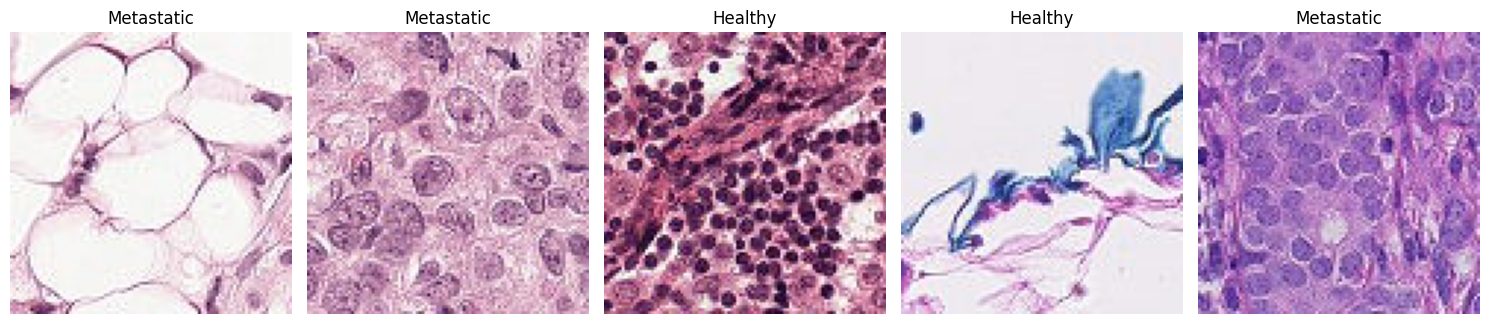

In [7]:
# Visualizing a few images of the training set
SampleVisualization(train_images, train_labels, num_samples=5)

# Splitting the dataset

In [8]:
# Checking how the dataset is split.
total_data_number = train_images.shape[0] + val_images.shape[0] + test_images.shape[0]
print(f"There are in total {total_data_number} images in the whole dataset split into \n{train_images.shape[0]/total_data_number*100}% big training set"
      f"\n{val_images.shape[0]/total_data_number*100}% big validation set \n{test_images.shape[0]/total_data_number*100}% big test set")

There are in total 327680 images in the whole dataset split into 
80.0% big training set
10.0% big validation set 
10.0% big test set


As we can see above the dataset is already divided into a $80\%$ training, $10\%$ validation and $10\%$ test set. Therefore to redo this step would be redundant. 

In [9]:
# Preparing the training data for the 5-fold crossvalidation.
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
for train_index, val_index in kf.split(train_images):
    print(f"Fold {fold}:")
    print(f"  Train indices: {train_index[:5]}...")  # Showing first 10 indices
    print(f"  Val indices: {val_index[:5]}...")
    fold += 1

Fold 1:
  Train indices: [0 1 2 3 4]...
  Val indices: [ 6 11 12 22 24]...
Fold 2:
  Train indices: [2 3 5 6 7]...
  Val indices: [ 0  1  4 20 35]...
Fold 3:
  Train indices: [0 1 2 4 5]...
  Val indices: [ 3 21 23 29 30]...
Fold 4:
  Train indices: [0 1 3 4 5]...
  Val indices: [ 2  7  8  9 13]...
Fold 5:
  Train indices: [0 1 2 3 4]...
  Val indices: [ 5 10 15 16 18]...


# Classifier using PhyTorch

We will create our image classification using CNN (Convolutional Neural Network), which is a well established data architecture. It is a supervised machine learning methodology used mainly in image processing or speech recognition.

In [24]:
# Converting the numpy arrays into the tensors used by PyTorch
train_images_tensor = torch.tensor(train_images, dtype=torch.float32).permute(0, 3, 1, 2)  # Training images
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)  # Training labels

val_images_tensor = torch.tensor(val_images, dtype=torch.float32).permute(0, 3, 1, 2)  # Validation images
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)  # Validation labels

test_images_tensor = torch.tensor(test_images, dtype=torch.float32).permute(0, 3, 1, 2)  # Test images
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)  # Test labels

In [ ]:
# We need to make the label tensors 1D

train_labels_tensor = train_labels_tensor.view(-1)
val_labels_tensor = val_labels_tensor.view(-1)
test_labels_tensor = test_labels_tensor.view(-1)

In [59]:
# Class and functions for the ML training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defining the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  # Input: 96x96x3 -> Output: 96x96x16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # Input: 96x96x16 -> Output: 96x96x32
        self.pool = nn.MaxPool2d(2, 2)  # Reduces dimensions by half
        self.relu = nn.ReLU()
        
        # After 2 Conv layers + pooling: input size 96x96 -> 24x24
        # The output size is 32 channels, and the image size will be 24x24
        self.flatten_size = 32 * 24 * 24  # Channels * Height * Width = 32 * 24 * 24 = 18432

        self.fc1 = nn.Linear(self.flatten_size, 128)  # Adjusted flatten size
        self.fc2 = nn.Linear(128, 2)  # Binary classification
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.relu(self.conv1(x))  # Apply Conv1 + ReLU
        x = self.pool(x)  # MaxPool2d
        x = self.relu(self.conv2(x))  # Apply Conv2 + ReLU
        x = self.pool(x)  # MaxPool2d
        x = self.flatten(x)  # Flatten the output
        x = self.relu(self.fc1(x))  # Fully connected layer 1
        x = self.fc2(x)  # Fully connected layer 2 (output layer)
        return x


# Defining the training algorithm    
def CNNTrainer(model, optimizer, criterion, train_loader):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    return running_loss / len(train_loader)

# Defining the model accuracy evaluation
def Evaluate(model, loader):
    model.eval()
    test_correct = 0
    test_total = 0
    test_predictions = []
    test_targets = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_predictions.extend(predicted.cpu().numpy())
            test_targets.extend(labels.cpu().numpy())
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

    # Test Accuracy
    test_accuracy = test_correct / test_total
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(test_targets, test_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Tumor", "Tumor"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    

In [53]:
# Initialize the model, loss function, and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(TensorDataset(train_images_tensor, train_labels_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_images_tensor, val_labels_tensor), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(test_images_tensor, test_labels_tensor), batch_size=batch_size, shuffle=False)

print("Dataloaders created!")

# Training and validating the model
num_epochs = 4
for epoch in range(num_epochs):
    train_loss = CNNTrainer(model, optimizer, criterion, train_loader)
    val_loss, val_accuracy = evaluate(model, criterion, val_loader)
    print(f"Epoch {epoch + 1}/{num_epochs} -> Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

print("Training Done!")

Dataloaders created!
Epoch 1/4 -> Train Loss: 0.5263, Val Loss: 0.4704, Val Accuracy: 0.7660
Epoch 2/4 -> Train Loss: 0.3903, Val Loss: 0.4889, Val Accuracy: 0.7743
Epoch 3/4 -> Train Loss: 0.3340, Val Loss: 0.4583, Val Accuracy: 0.7955
Epoch 4/4 -> Train Loss: 0.2960, Val Loss: 0.5383, Val Accuracy: 0.7906
Training Done!


Test Accuracy: 0.7307


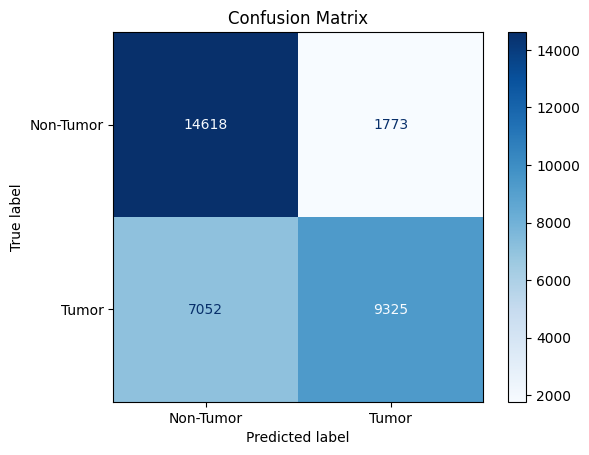

In [60]:
Evaluate(model, test_loader)